In [6]:
import illustris_python as il
import mistree as mist
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import astropy.units as u
import astropy.constants as c
import pandas as pd
import networkx as nx
import seaborn as sns
import scienceplots

from sklearn.neighbors import radius_neighbors_graph, KernelDensity

from scipy.spatial import Delaunay
from scipy.spatial.distance import euclidean, minkowski
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer


import Utilities as ut
import Network_stats as ns

plt.style.use(['science','no-latex'])

In [2]:
testnet = ns.network(masscut=1e10)
testnet.subhalo_delauany_network(xyzplot=False)
testnet.cweb_classify(xyzplot=False)
testnet.network_stats_delaunay()

There are 97233 subhalos with stellar mass greater than 0.6774.
length before buffering:  97233
length after buffering:  97233


In [7]:
# Feature scaling
features = testnet.data.iloc[:,:-1] # All columns except the last one
targets = testnet.data.iloc[:,-1] # The last column

scaler = StandardScaler()
scaler = PowerTransformer(method = 'box-cox')
features = pd.DataFrame(scaler.fit_transform(features), index=features.index, columns=features.columns)

In [8]:
targets

Node ID
0        3.0
1        3.0
2        3.0
3        3.0
4        3.0
        ... 
97228    3.0
97229    2.0
97230    2.0
97231    2.0
97232    2.0
Name: Target, Length: 97233, dtype: float64

In [9]:
features

,Degree,Mean E.L.,Min E.L.,Max E.L.,Clustering,Density,Neigh Density
Node ID,,,,,,,
0,-2.014559,-2.209860,-1.335262,-2.392986,-2.295939,2.042591,1.869320
1,-2.059378,-2.218986,-1.183516,-2.626377,-2.272979,2.058843,1.913680
2,-1.954994,-2.009095,-1.978620,-2.299263,-1.962275,1.903202,1.717409
3,-1.853995,-1.740171,-1.834865,-1.977976,-1.559856,1.644824,1.250023
4,-1.510958,-1.733531,-0.903389,-2.064904,-1.842394,1.680096,1.453322
...,...,...,...,...,...,...,...
97228,0.053082,-0.500748,-0.112606,-0.008822,-1.035789,0.317239,0.958145
97229,-0.023423,-0.155902,-0.126290,0.707216,-0.190483,-0.277348,1.168144
97230,-0.542188,-0.926087,0.100690,-1.275551,-1.244007,0.902818,0.648846


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric
from torch_geometric.datasets import Planetoid, ZINC, GNNBenchmarkDataset
from torch_scatter import scatter_mean, scatter_max, scatter_sum
from torch_geometric.utils import to_dense_adj
from torch.nn import Embedding


In [71]:
class mlp(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels):
        super(mlp, self).__init__()
        self.layer1 = nn.Linear(in_channels, 10)
        self.layer2 = nn.Linear(10, 10)
        self.layer3 = nn.Linear(10, out_channels)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

def train_mlp(model, optimiser, train_loader, val_loader, epochs, criterion):
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for data in train_loader:
            inputs, labels = data
            optimiser.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimiser.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(100 * correct / total)

        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss.append(running_loss / len(val_loader))
        val_acc.append(100 * correct / total)

        if epoch % 10 == 0:
            print(f'Epoch: {epoch}, Train Loss: {train_loss[-1]}, Train Acc: {train_acc[-1]}, Val Loss: {val_loss[-1]}, Val Acc: {val_acc[-1]}')

    return train_loss, train_acc, val_loss, val_acc

def train_model(model, optimiser, train_loader, valid_loader, num_epochs, criterion):
    train_loss = []
    valid_loss = []
    train_accuracy = []
    valid_accuracy = []
    # model.layers.apply(initialise_weights)

    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', factor=0.95, patience=2, cooldown=3) # Dynamically reduce the learning rate when the validation loss plateaus


    for epoch in range(num_epochs):
        model.train()

        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimiser.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimiser.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss.append(running_loss/len(train_loader))
        train_accuracy.append(100 * correct / total)
        
        model.eval() # set the model to evaluation mode
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for features, labels in valid_loader:
                outputs = model(features)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            valid_loss.append(running_loss/len(valid_loader))
            valid_accuracy.append(100 * correct / total)
        model.train() # set the model back to training mode

        # scheduler.step(valid_loss[-1]) 
        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss[-1]:.4f} - Training Accuracy: {train_accuracy[-1]:.2f}% - Validation Loss: {valid_loss[-1]:.4f} - Validation Accuracy: {valid_accuracy[-1]:.2f}% - LR: {optimiser.param_groups[0]["lr"]}')

    return train_loss, valid_loss, train_accuracy, valid_accuracy

# def test_mlp(model, test_loader):
#     model.eval()
#     correct = 0
#     total = 0
#     all_preds = []
#     all_labels = []
#     with torch.no_grad():
#         for data in test_loader:
#             inputs, labels = data
#             outputs = model(inputs)
#             _, predicted = outputs.max(1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#             all_preds.append(predicted)
#             all_labels.append(labels)
#     print(f'Test Accuracy: {100 * correct / total}')
#     return all_preds, all_labels

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.tolist())
            all_labels.extend(labels.tolist())
    print(f'Test Accuracy: {100 * correct / total:.2f}%')
    return all_preds, all_labels

In [50]:
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(targets), y = targets)
class_weights = torch.tensor(class_weights, dtype=torch.float) # Convert to tensor
print(class_weights)

tensor([12.0997,  1.2009,  0.5200,  0.8609])


In [51]:
train_x, test_x, train_y, test_y = train_test_split(features, targets, test_size=0.2, random_state=42, stratify=targets)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42, stratify=train_y)

In [52]:
train_y.value_counts()

Target
2.0    29917
3.0    18071
1.0    12954
0.0     1286
Name: count, dtype: int64

In [84]:
class CustomDataset(Dataset):
    def __init__(self, x, y, classes):
        self.x = torch.tensor(x.values, dtype=torch.float)
        self.y = torch.tensor(y.values, dtype=torch.long)
        self.classes = classes

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
classes = ['Void (0)', 'Wall (1)', 'Filament (2)', 'Cluster (3)']

train_dataset = CustomDataset(train_x, train_y, classes)
val_dataset = CustomDataset(val_x, val_y, classes)
test_dataset = CustomDataset(test_x, test_y, classes)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [89]:
# Debugging main preprocessing module

testnet.pipeline(network_type='Delaunay')

length before buffering:  97233
length after buffering:  97233
Class weights:  [12.09967646  1.20088183  0.52000706  0.86089567]


In [90]:
model = mlp(in_channels=features.shape[1], out_channels=len(classes), hidden_channels=10)
optimiser = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss(weight=class_weights) #torch.tensor([0.7237, 0.1130, 0.0609, 0.1024]))
train_loss, valid_loss, train_accuracy, valid_accuracy = train_model(model, optimiser, testnet.train_loader, testnet.val_loader, 100, criterion)

Epoch 10/100 - Training Loss: 0.9082 - Training Accuracy: 64.59% - Validation Loss: 0.8998 - Validation Accuracy: 65.31% - LR: 1e-05
Epoch 20/100 - Training Loss: 0.7603 - Training Accuracy: 69.60% - Validation Loss: 0.7601 - Validation Accuracy: 68.97% - LR: 1e-05
Epoch 30/100 - Training Loss: 0.7128 - Training Accuracy: 68.93% - Validation Loss: 0.7167 - Validation Accuracy: 68.42% - LR: 1e-05
Epoch 40/100 - Training Loss: 0.6988 - Training Accuracy: 68.61% - Validation Loss: 0.7030 - Validation Accuracy: 68.09% - LR: 1e-05
Epoch 50/100 - Training Loss: 0.6925 - Training Accuracy: 68.58% - Validation Loss: 0.6976 - Validation Accuracy: 68.11% - LR: 1e-05
Epoch 60/100 - Training Loss: 0.6886 - Training Accuracy: 68.50% - Validation Loss: 0.6952 - Validation Accuracy: 68.14% - LR: 1e-05
Epoch 70/100 - Training Loss: 0.6881 - Training Accuracy: 68.49% - Validation Loss: 0.6936 - Validation Accuracy: 68.07% - LR: 1e-05
Epoch 80/100 - Training Loss: 0.6862 - Training Accuracy: 68.49% - Va

In [85]:
model = mlp(in_channels=features.shape[1], out_channels=len(classes), hidden_channels=10)
optimiser = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss(weight=class_weights) #torch.tensor([0.7237, 0.1130, 0.0609, 0.1024]))
train_loss, valid_loss, train_accuracy, valid_accuracy = train_model(model, optimiser, train_loader, val_loader, 100, criterion)
# preds, labels = test_mlp(model, test_loader)

Epoch 10/100 - Training Loss: 0.8639 - Training Accuracy: 60.68% - Validation Loss: 0.8577 - Validation Accuracy: 61.25% - LR: 1e-05
Epoch 20/100 - Training Loss: 0.7542 - Training Accuracy: 67.40% - Validation Loss: 0.7594 - Validation Accuracy: 67.07% - LR: 1e-05
Epoch 30/100 - Training Loss: 0.7179 - Training Accuracy: 67.30% - Validation Loss: 0.7261 - Validation Accuracy: 67.20% - LR: 1e-05
Epoch 40/100 - Training Loss: 0.7020 - Training Accuracy: 67.31% - Validation Loss: 0.7128 - Validation Accuracy: 67.26% - LR: 1e-05
Epoch 50/100 - Training Loss: 0.6938 - Training Accuracy: 67.47% - Validation Loss: 0.7072 - Validation Accuracy: 67.18% - LR: 1e-05
Epoch 60/100 - Training Loss: 0.6908 - Training Accuracy: 67.55% - Validation Loss: 0.7044 - Validation Accuracy: 67.01% - LR: 1e-05
Epoch 70/100 - Training Loss: 0.6867 - Training Accuracy: 67.59% - Validation Loss: 0.7032 - Validation Accuracy: 67.07% - LR: 1e-05
Epoch 80/100 - Training Loss: 0.6850 - Training Accuracy: 67.64% - Va

In [91]:
preds, labels = test_model(model, testnet.test_loader)

Test Accuracy: 68.80%


In [92]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(labels, preds, target_names=classes))
print(confusion_matrix(labels, preds))


              precision    recall  f1-score   support

    Void (0)       0.32      0.67      0.43       402
    Wall (1)       0.56      0.66      0.60      4049
Filament (2)       0.76      0.62      0.68      9349
 Cluster (3)       0.75      0.83      0.79      5647

    accuracy                           0.69     19447
   macro avg       0.60      0.69      0.63     19447
weighted avg       0.71      0.69      0.69     19447

[[ 270  129    3    0]
 [ 526 2677  835   11]
 [  53 1972 5761 1563]
 [   1   24  950 4672]]


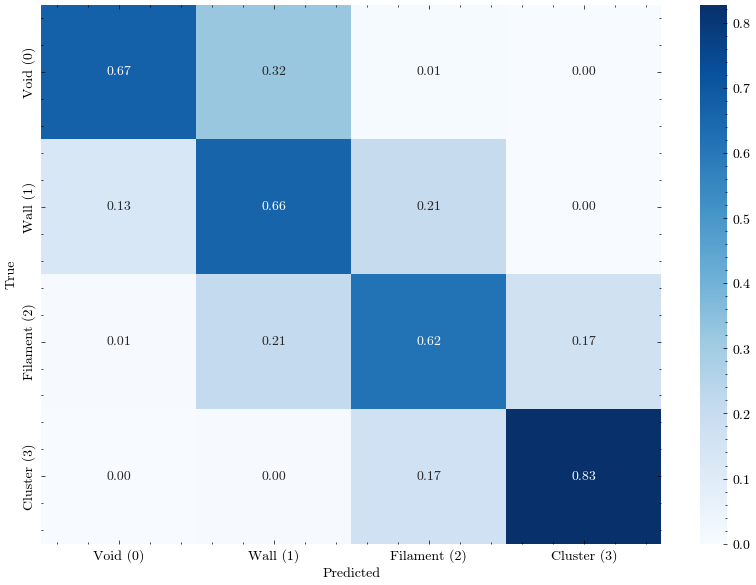

In [93]:
# normalised confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
classes = ['Void (0)','Wall (1)', 'Filament (2)', 'Cluster (3)']
cm = confusion_matrix(y_true=labels, y_pred=preds)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='.2f',cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Ok we have found that the problem in the main pipeline is not to do with network_stats.py, it could be to do with the model set up or with the plotting